In [2]:
library(dplyr)
source("~/sc-online/utils.R")

getWideMat = function(mat, row_colname, col_colname, data_colname, is_triangular=FALSE){

    unique_rows = unique(mat[[row_colname]])
    unique_cols = unique(mat[[col_colname]])

    # Create an empty matrix
    mat_wide <- matrix(nrow = length(unique_rows), ncol = length(unique_cols),
                                dimnames = list(unique_rows, unique_cols))

    # Loop over each row of the long matrix
    for (i in 1:nrow(mat)) {
        # Get the current row
        row <- mat[i, ]

        # Assign the value of V4 to the corresponding cell in the matrix
        mat_wide[row[[row_colname]], row[[col_colname]]] <- row[[data_colname]]
    }
    if(is_triangular){
        # THERE WILL BE ONE COL AND ONE ROW MISSING.
        # ADD AN ALL NA COLUMN, AND THEN AN ALL NA ROW
        missing_colname = setdiff(unique_cols, unique_rows)
        missing_rowname = setdiff(unique_rows, unique_cols)

        mat_wide = rbind(NA, mat_wide)
        rownames(mat_wide)[1] = missing_rowname
        mat_wide = cbind(mat_wide, NA)
        colnames(mat_wide)[ncol(mat_wide)] = missing_colname

        mat_wide[upper.tri(mat_wide)] = mat_wide[lower.tri(mat_wide)]
    }
    return(mat_wide)

}

getGroups = function(
    discomat, 
    gt_check_type = "between",
    key_colname = "V2", 
    value_colname="V3", 
    data_colname="V4", 
    disco_cutoff=3e7){

    if (gt_check_type == "between"){
        is_triangular = FALSE
    } else {
        is_triangular = TRUE
    }

    discomat_wide = getWideMat(discomat, value_colname, key_colname, data_colname, is_triangular)

    groups = list()

    if (gt_check_type == "between"){
        for (colname in colnames(discomat_wide)){
            col = discomat_wide[, colname]
            if (min(col) < disco_cutoff){
                groups[[colname]] = rownames(discomat_wide)[col < disco_cutoff]
            }
        }
    }

    
    if (gt_check_type == "within") {
        # Get row and column pairs where the data is less than the cutoff
        indices <- which(discomat_wide < disco_cutoff, arr.ind = TRUE)  
        row_names <- dimnames(discomat_wide)[[1]][indices[,1]]
        col_names <- dimnames(discomat_wide)[[2]][indices[,2]]

        # Combine row and column names into a data frame
        name_pairs <- data.frame(row = row_names, column = col_names)

        groups = list()
        for (i in 1:nrow(name_pairs)) {
            rowval = name_pairs[i,1]
            colval = name_pairs[i,2]

            # if groups is empty, just add the first pair
            if (length(groups) == 0) {
                groups[[1]] = c(rowval, colval)
                next
            }

            # Check if any sublist in 'groups' contains both 'rowval' and 'colval'
            if (any(sapply(groups, function(x) {rowval %in% x & colval %in% x}))) {
                #print(paste("both in:", rowval, colval))
                next
            }
            
            # Check if any sublist in 'groups' contains 'rowval' or 'colval'
            rowval_index = which(sapply(groups, function(x) {rowval %in% x}))
            colval_index = which(sapply(groups, function(x) {colval %in% x}))

            if (length(rowval_index) == 1 & length(colval_index) == 0) {
                #print(paste("rowval in, colval not:", rowval, colval)) 
                groups[[rowval_index]] = c(groups[[rowval_index]], colval)
                next
            }
            
            if (length(colval_index) == 1 & length(rowval_index) == 0){
                #print(paste("colval in, rowval not:", rowval, colval))
                groups[[colval_index]] = c(groups[[colval_index]], rowval)
                next
            }
            
            # If neither have an index, create a new group
            if (length(rowval_index) == 0 & length(colval_index) == 0) {
                #print(paste("neither in:", rowval, colval))
                groups[[length(groups) + 1]] = c(rowval, colval)
            }
        }    
    }
    
    #sort groups by the length of their objects
    groups = groups[order(sapply(groups, length), decreasing = T)]

    # for every group, join elements together with the '|' delimeter 
    groups = lapply(groups, function(x) paste(sort(x), collapse = "|"))

    # return the groups
    return(groups)

}

[1] 9120    6

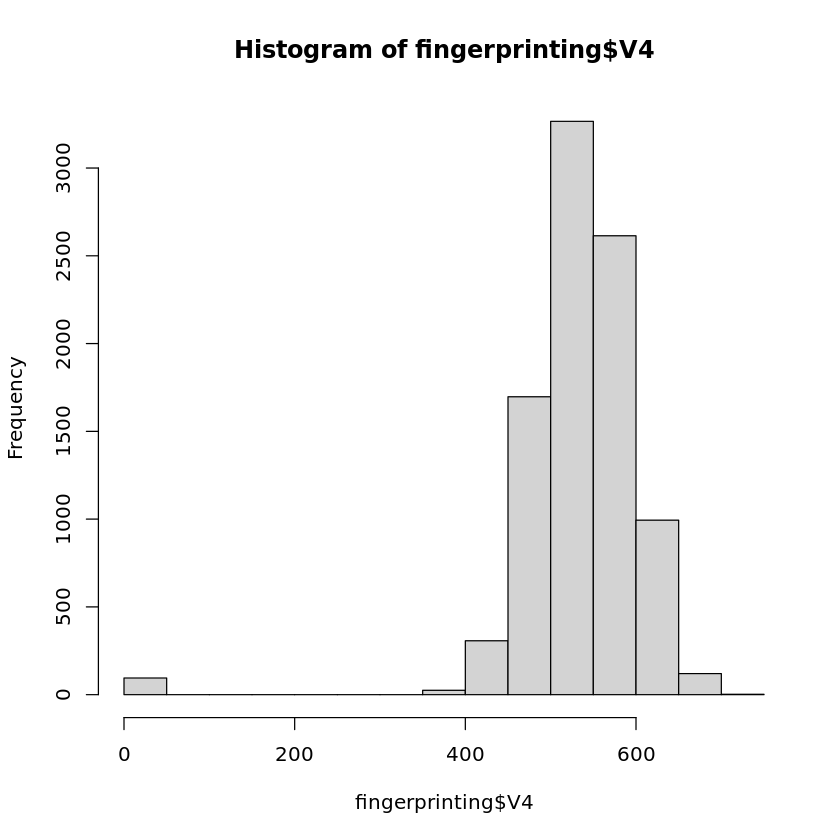

In [3]:
fingerprinting = read.table("/mnt/accessory/seq_data/calico/all_libs/calico_fingerprinting", header = F, sep = "\t", skip=17)
hist(fingerprinting$V4)
dim(fingerprinting)

In [4]:
fgs = getGroups(fingerprinting, key_colname="V2", value_colname="V3", gt_check_type="between", disco_cutoff=200)
length(unique(fingerprinting$V3))
length(unique(fingerprinting$V2))
length(fgs)

# gt_groups = getGroups(internal_gt, key_colname="V3", value_colname="V2", gt_check_type="within", disco_cutoff=1e6)
# length(unique(internal_gt$V3))
# length(unique(internal_gt$V2))
# length(gt_groups)


[1] 76

[1] 120

[1] 90

In [ ]:
deduped_samples = readLines("/mnt/accessory/seq_data/calico/all_libs/calico_post_impute.bf7.deduped_samples.txt")
all_samples = readLines("/mnt/accessory/seq_data/calico/all_libs/all-chipwells.txt")
internal_gt = read.table("/mnt/accessory/seq_data/calico/all_libs/calico_post_impute.bf7.gtcheck", header = F, sep = "\t", skip=17)
internal_gt = internal_gt[!duplicated(internal_gt),]
internal_gt = internal_gt[order(internal_gt$V2, internal_gt$V3),]
hist(internal_gt$V4)

In [47]:

prelim_groups = internal_gt[internal_gt$V4 < 1e7,]
dim(prelim_groups)

groups = list()
for (i in 1:nrow(prelim_groups)){
    v2 = prelim_groups[i, "V2"]
    v3 = prelim_groups[i, "V3"]

    if (length(groups) == 0) {
        groups[[1]] = c(v2, v3)
        next
    }
    
    v2_index = which(sapply(groups, function(x) {v2 %in% x}))
    v3_index = which(sapply(groups, function(x) {v3 %in% x})) 

    if (length(v2_index) == 1 & length(v3_index) == 1) {
        next
    }
    if (length(v2_index) == 1 & length(v3_index) == 0) {
        groups[[v2_index]] = c(groups[[v2_index]], v3)
        next
    }
    if (length(v3_index) == 1 & length(v2_index) == 0){
        groups[[v3_index]] = c(groups[[v3_index]], v2)
        next
    }
    if (length(v2_index) == 0 & length(v3_index) == 0) {
        groups[[length(groups) + 1]] = c(v2, v3)
    }
}
#sort groups by the length of their objects
groups_list = groups[order(sapply(groups, length), decreasing = T)]

# for every group, join elements together with the ',' delimeter 
groups = lapply(groups_list, function(x) paste(sort(x), collapse = ","))

# flatten the list of lists
groups_flat = unlist(groups_list, recursive=F)
first_groups = sapply(groups_list, function(x) x[1])
singletons = setdiff(deduped_samples, groups_flat)

new_deduped_samples = c(first_groups, singletons)

writeLines(new_deduped_samples, "/mnt/accessory/seq_data/calico/all_libs/calico_post_impute.bf7.new_deduped_samples.txt")


[1] 25  6

In [48]:
first_groups

[1] "206954930093_R05C02_1" "207762950086_R04C01_1" "207762950108_R07C02_1"
 [4] "206954930011_R11C01_1" "207762950055_R02C01_1" "207762950055_R03C02_1"
 [7] "207762950055_R05C02_1" "207762950055_R10C02_1" "207762950055_R12C02_1"
[10] "207762950086_R02C01_1" "207762950086_R03C02_1" "207762950086_R05C02_1"
[13] "207762950086_R10C02_1" "207762950108_R01C02_1" "207762950108_R03C02_1"
[16] "207762950108_R10C02_1" "207762960003_R05C02_1" "207762960003_R09C01_1"
[19] "207762960003_R12C02_1"

In [39]:
sort(setdiff(new_deduped_samples, deduped_samples))
sort(setdiff(deduped_samples, new_deduped_samples))

[1] "206954930011_R11C01_1" "206954930093_R05C02_1" "207762950086_R02C01_1"
[4] "207762950086_R04C01_1" "207762950108_R07C02_1" "207762950108_R10C02_1"
[7] "207762960003_R12C02_1"

[1] "206954930010_R04C01_1" "206954930010_R07C01_1" "206954930010_R11C01_1"
[4] "206954930011_R06C02_1" "206954930060_R11C01_1" "207762960003_R02C01_1"
[7] "207762960003_R10C02_1"

In [50]:
print(singletons)

 [1] "206954930093_R04C02_1" "206954930011_R10C02_1" "206954930011_R12C02_1"
 [4] "206954930060_R07C02_1" "206954930060_R10C02_1" "206954930093_R07C02_1"
 [7] "206954930010_R09C01_1" "206954930011_R11C02_1" "206954930010_R03C02_1"
[10] "206954930010_R05C01_1" "206954930010_R08C01_1" "206954930010_R10C01_1"
[13] "206954930011_R04C01_1" "206954930011_R04C02_1" "206954930011_R05C01_1"
[16] "206954930011_R08C02_1" "206954930060_R02C02_1" "206954930060_R04C01_1"
[19] "206954930060_R10C01_1" "206954930060_R12C01_1" "206954930093_R02C01_1"
[22] "206954930093_R06C02_1" "206954930093_R07C01_1" "206954930093_R08C01_1"
[25] "207762950086_R06C02_1" "207762950086_R07C02_1" "207762950086_R11C01_1"
[28] "207762950108_R04C01_1" "206954930010_R05C02_1" "206954930060_R11C02_1"
[31] "207762950055_R11C01_1" "206954930010_R01C01_1" "206954930010_R01C02_1"
[34] "206954930010_R02C01_1" "206954930010_R03C01_1" "206954930010_R06C01_1"
[37] "206954930011_R01C02_1" "206954930011_R02C02_1" "206954930011_R03C01_1"

In [46]:
sums = list()
for (i in 1:length(groups_list)){
    group = groups_list[[i]]
    sums[[i]] = sum(group %in% deduped_samples)
}
sums

[[1]]
[1] 1

[[2]]
[1] 1

[[3]]
[1] 1

[[4]]
[1] 1

[[5]]
[1] 1

[[6]]
[1] 1

[[7]]
[1] 1

[[8]]
[1] 1

[[9]]
[1] 1

[[10]]
[1] 0

[[11]]
[1] 1

[[12]]
[1] 2

[[13]]
[1] 1

[[14]]
[1] 1

[[15]]
[1] 1

[[16]]
[1] 1

[[17]]
[1] 1

[[18]]
[1] 1

[[19]]
[1] 1

In [53]:
groups_list[[10]]

[1] "207762950086_R02C01_1" "206954930093_R03C02_1"

In [52]:
groups_list[[12]]

[1] "207762950086_R05C02_1" "206954930010_R07C01_1"

In [22]:
setdiff(deduped_samples, all_samples)

character(0)

In [21]:
length(groups) + length(singletons)

[1] 98

In [18]:
19 + 79

[1] 98

In [13]:
chipwell_barcodes = names(fgs)
participant_ids = as.character(unlist(fgs))
mapping = data.frame(participant_id = participant_ids, chipwell_barcode = chipwell_barcodes)
mapping = mapping[order(mapping$participant_id),]
# write.table(
#     mapping, 
#     "/mnt/accessory/seq_data/calico/all_libs/calico_fingerprinting_mapping.tsv", sep = "\t", quote = F, row.names = F, col.names = T
# )



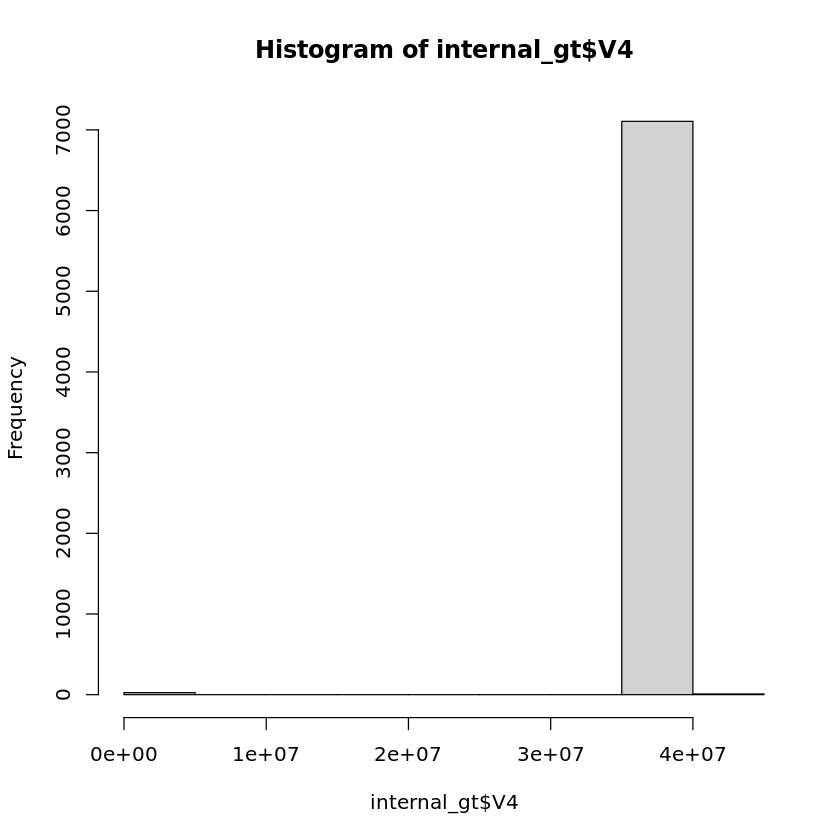

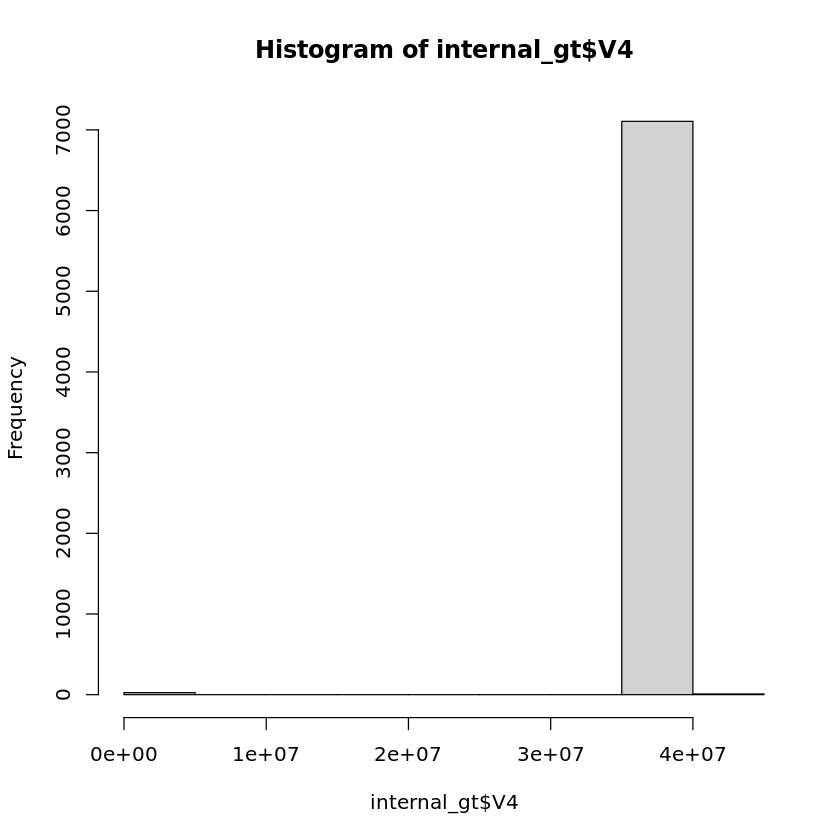

In [13]:
representatives = list()
for (i in 1:length(groups)){
    group_str = groups[[i]]
    group = strsplit(group_str, split = ",")[[1]]

    for (g in group){
        if (g %in% deduped_samples){
            # representatives[[g]] = group_str
            if (g %in% representatives){
                stop(paste("Duplicate representative found:", g))
            }
            if (length(representatives) > i){
                stop(paste("Representative already found for group:", group_str))
            }
            representatives[[i]] = g
        }
    }
}
representatives

[[1]]
[1] "206954930010_R04C01_1"

[[2]]
[1] "207762960003_R10C02_1"

[[3]]
[1] "207762960003_R02C01_1"

[[4]]
[1] "206954930010_R11C01_1"

[[5]]
[1] "207762950055_R02C01_1"

[[6]]
[1] "207762950055_R03C02_1"

[[7]]
[1] "207762950055_R05C02_1"

[[8]]
[1] "207762950055_R10C02_1"

[[9]]
[1] "207762950055_R12C02_1"

[[10]]
NULL

[[11]]
[1] "207762950086_R03C02_1"

[[12]]
[1] "207762950086_R05C02_1"

[[13]]
[1] "207762950086_R10C02_1"

[[14]]
[1] "207762950108_R01C02_1"

[[15]]
[1] "207762950108_R03C02_1"

[[16]]
[1] "206954930011_R06C02_1"

[[17]]
[1] "207762960003_R05C02_1"

[[18]]
[1] "207762960003_R09C01_1"

[[19]]
[1] "206954930060_R11C01_1"

[[1]]
[1] "206954930010_R04C01_1"

In [61]:
a

[1] "206954930060_R11C01_1" "207762960003_R12C02_1"

In [64]:
a = list()
a[[1]] = 'a'